In [24]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from main import get_market_data
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
market_data = get_market_data(mean_volume = 3000) #Movements, O, H, L, C

- 2MX.PA: No data found, symbol may be delisted
- ASP.PA: No data found, symbol may be delisted
- ACNV.PA: No data found, symbol may be delisted
- ABIO.PA: No data found, symbol may be delisted
- CDANV.PA: No data found, symbol may be delisted
- ALMDS.PA: No data found, symbol may be delisted
- ALM.PA: No data found, symbol may be delisted
- ATA.PA: No data found, symbol may be delisted
- FBEL.PA: No data found, symbol may be delisted
- CAPLI.PA: No data found, symbol may be delisted
- CGGBS.PA: No data found, symbol may be delisted
- CIB.PA: No data found, symbol may be delisted
- CNP.PA: No data found, symbol may be delisted
- DLTA.PA: No data found, symbol may be delisted
- DVT.PA: No data found, symbol may be delisted
- DGM.PA: No data found, symbol may be delisted
- GID.PA: No data found, symbol may be delisted
- ECP.PA: No data found, symbol may be delisted
- EUCAR.PA: No data found, symbol may be delisted
- FAUV.PA: No data found, symbol may be delisted
- FPN.PA: No data found, 

In [25]:
from sklearn.decomposition import PCA
from tslearn.clustering import silhouette_score

km_rand_st = 8

def winsorize_col(s):
    return winsorize(s, limits=[0.005,0.005])

def pca_analysis(df, min_variance=90, lookback = 365):
    cluster_db = df.iloc[:,-lookback:]
    scaler = StandardScaler()
    scaler.fit(cluster_db)    
    #normalize data
    cluster_db_norm = scaler.transform(cluster_db)
    pca = PCA(n_components = 249)
    pca.fit(cluster_db_norm)
    eigen_values, eigein_values_ratio = pca.explained_variance_, pca.explained_variance_ratio_
    plt.plot(eigen_values,alpha=0.5)
    print(f'Keyser : {len(eigen_values[eigen_values > 1])}, {min_variance} % of variance : {len(eigein_values_ratio.cumsum()[eigein_values_ratio.cumsum() < min_variance/100])}')

def pca_df(df, n_comp):
    pca = PCA(n_components = n_comp)
    pca.fit(df)
    df_pca = pd.DataFrame(pca.transform(df), index =df.index)
    return df_pca

def get_elbow_curve(df, min_clusters, max_clusters):
    inertia = np.array([])
    silhouette= np.array([])
    for k in tqdm(range(min_clusters, max_clusters)):
        #, metric='dtw'
        TSKmeans = KMeans(n_clusters=k, n_init=20, random_state=km_rand_st).fit(df)
        inertia = np.append(inertia, TSKmeans.inertia_)
        silhouette = np.append(silhouette, silhouette_score(df, TSKmeans.labels_, metric='euclidean'))
    plt.plot(range(min_clusters,max_clusters),inertia)
    plt.show()
    plt.plot(range(min_clusters,max_clusters),silhouette)
    plt.show()
    return inertia, silhouette

returns = market_data[3].pct_change().iloc[1:,:]
returns_win = returns.apply(winsorize_col, axis=0).T
returns_win_1y = returns_win.iloc[:,-365:]
returns=returns.T

Keyser : 98, 87 % of variance : 100


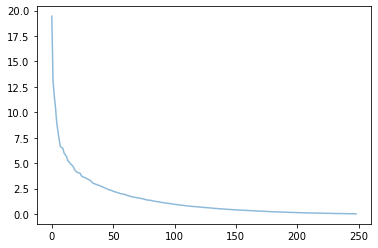

In [26]:
pca_analysis(returns_win_1y, min_variance=87)

100%|██████████| 238/238 [03:16<00:00,  1.21it/s]


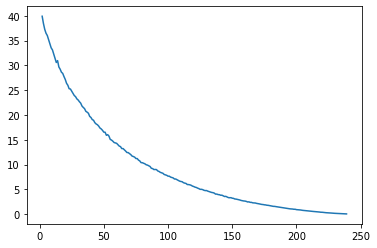

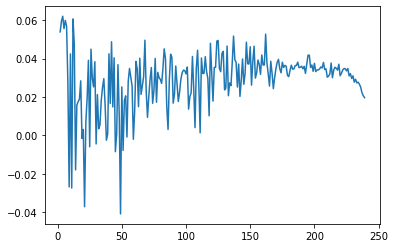

In [27]:
inert, silh = get_elbow_curve(pca_df(returns_win_1y, 98), min_clusters=2, max_clusters=240)

In [31]:
np.argsort(silh)[::-1][:40]+2

array([  4,  12,   6,   3,   7,   5,   2, 162, 137,  68, 125, 124,  42,
       147, 119,  13, 132, 153, 150,  83,  26, 109, 129, 128,  40,  10,
        88, 159, 196, 195, 105, 115,  89,  44, 112,  64,  76,  84, 144,
       172], dtype=int64)

In [32]:
from sklearn.cluster import KMeans
import math
def get_labels(df, n_clust, lookback = 365):
    #cluster_labels = TimeSeriesKMeans(n_clusters=n_clust, metric="dtw", n_init=10).fit(df.iloc[:,-lookback:])
    #metric="dtw"
    cluster_labels = KMeans(n_clusters=n_clust, n_init=20, random_state = km_rand_st).fit(df.iloc[:,-lookback:])
    print(f"inertia : {silhouette_score(df, cluster_labels.labels_, metric='euclidean')}")
    cluster_labels = pd.Series(cluster_labels.labels_, index = df.index)
    return cluster_labels

def print_cluster_results(cluster_labels, lookback = 365):
    #scale prices for visualisation
    euronext_close = market_data[3].T
    euronext_close_cumsum = market_data[3].pct_change().iloc[-365:,:].apply(winsorize_col, axis=0).cumsum().T
    n_clusters = (cluster_labels.value_counts() > 1).value_counts()[1]
    n_graphs_per_line = 3
    n_lines = math.ceil(n_clusters/n_graphs_per_line)
    fig, axs = plt.subplots(n_lines,n_graphs_per_line, figsize=(20,n_clusters))
    k = 0
    clust = cluster_labels.value_counts()[cluster_labels.value_counts() > 1].sort_index().index
    for i in range(n_lines):
        for j in range(n_graphs_per_line):
            try:
                if len(euronext_close_cumsum[cluster_labels==clust[k]].index)>1:
                    axs[i][j].plot(euronext_close_cumsum[cluster_labels==clust[k]].T)
                    axs[i][j].set_title('Stock Time Series for Cluster %d' % clust[k])
                k+=1
            except:
                None
    fig.tight_layout()
    plt.show()
    
def print_all_cluster_results(cluster_labels, lookback = 365):
    #scale prices for visualisation
    euronext_close = market_data[3].T
    euronext_close_cumsum = market_data[3].pct_change().iloc[-365:,:].apply(winsorize_col, axis=0).cumsum().T
    n_clusters = len(cluster_labels.value_counts())
    n_graphs_per_line = 3
    n_lines = math.ceil(n_clusters/n_graphs_per_line)
    fig, axs = plt.subplots(n_lines,n_graphs_per_line, figsize=(20,n_clusters))
    clust = 0
    for i in range(n_lines):
        for j in range(n_graphs_per_line):
            try:
                axs[i][j].plot(euronext_close_cumsum[cluster_labels==clust].T)
                axs[i][j].set_title('Stock Time Series for Cluster %d' % clust)
                clust+=1
            except:
                None
    fig.tight_layout()
    plt.show()

In [33]:
ret_pca_162 = get_labels(pca_df(returns_win_1y, 98), n_clust=162)

inertia : 0.05268487759077439


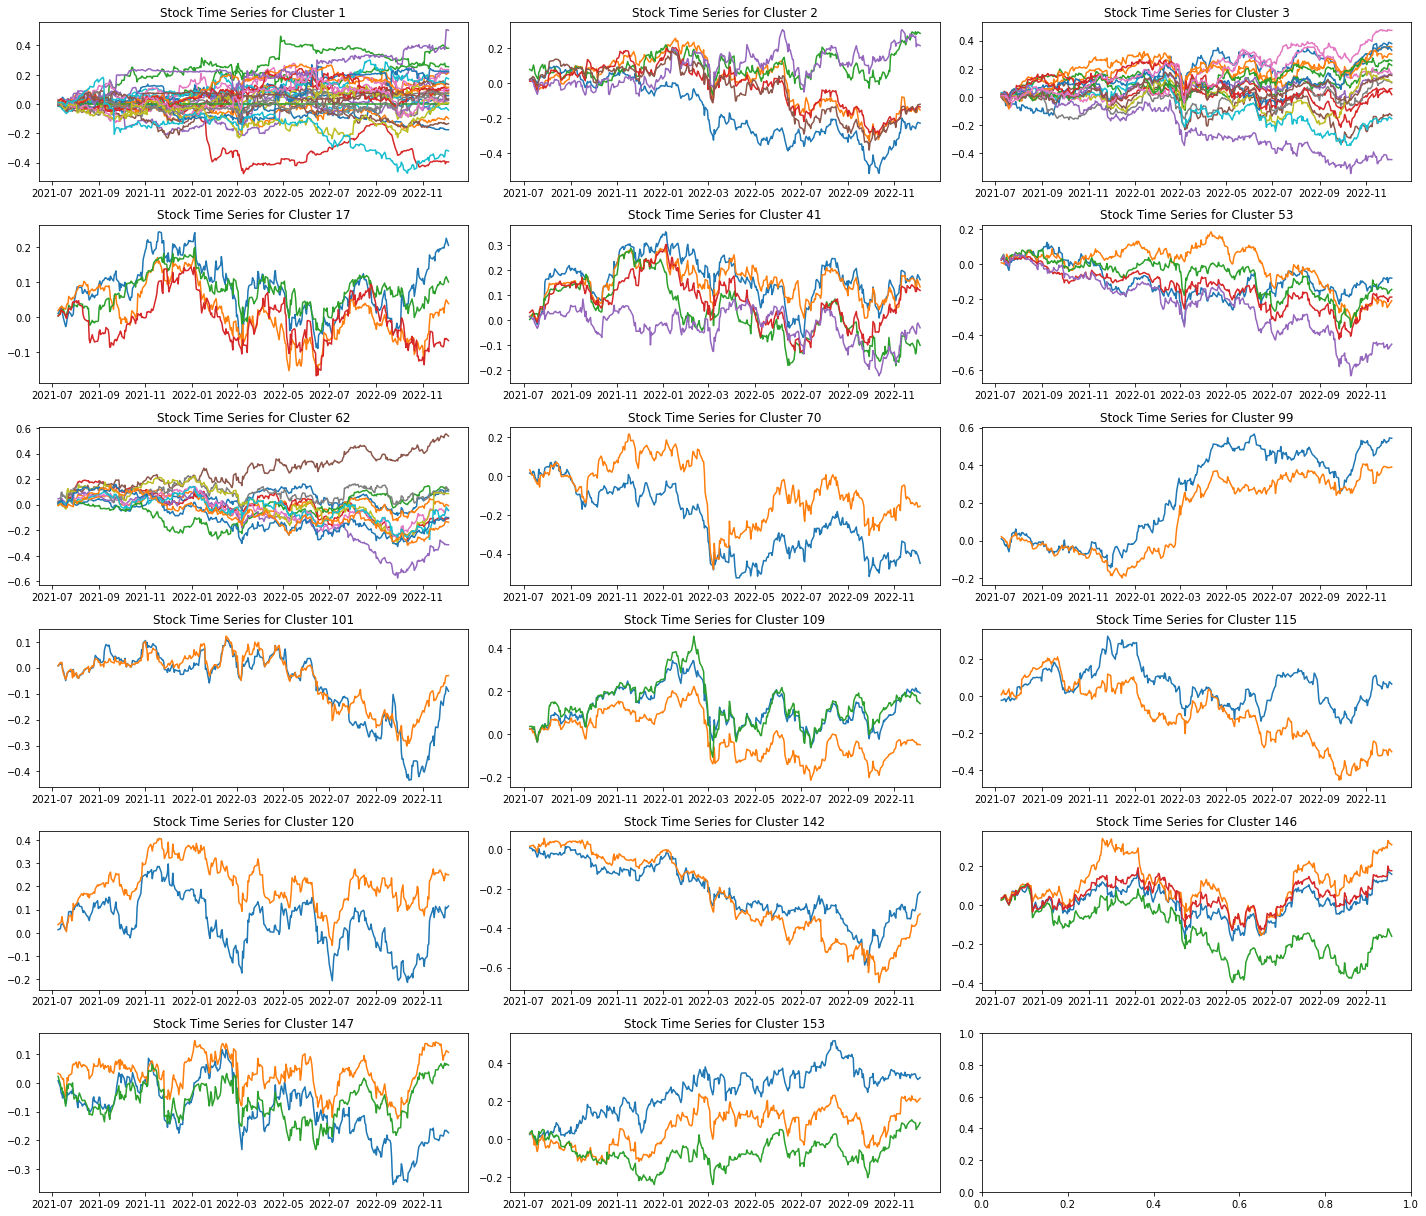

In [15]:
print_cluster_results(ret_pca_162)

In [34]:
import pickle
returns.T.to_pickle('returns.pickle')
ret_pca_162.to_pickle('clust_162.pickle')

In [ ]:
peut etre que algo performe mieux sur actions moins bien

In [ ]:
#une fois que c bon implementer ratios a la main et voir ratio de sharpe moyen par cluster / 
voir deature selection sur le medium

#clustering sur plusieurs unités de temps (1y, 2y ,6m, 3m)
#feature extraction tsfresh?

In [ ]:
faire fonction qui calcule moyenne corr par clusters

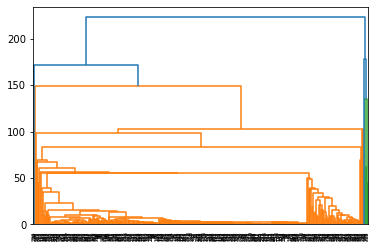

In [9]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

dendrogram_2021 = sch.dendrogram(sch.linkage(cluster_db_pca, method='ward'))
linkage = sch.linkage(cluster_db_pca,method='ward',optimal_ordering=True)

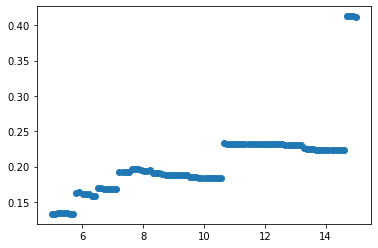

In [129]:
from sklearn.metrics import silhouette_score
plot = []
for i in np.linspace(5, 15, num=100):
    plot.append([i, silhouette_score(X=cluster_db,labels=fcluster(linkage,t=i,criterion='distance'))])
x, y = np.array(plot).T
plt.scatter(x, y)

In [130]:
plot

[[5.0, 0.13308634793312177],
 [5.101010101010101, 0.13308634793312177],
 [5.202020202020202, 0.13411120781390037],
 [5.303030303030303, 0.13411120781390037],
 [5.404040404040404, 0.13411120781390037],
 [5.505050505050505, 0.13411120781390037],
 [5.606060606060606, 0.133328066235819],
 [5.707070707070707, 0.133328066235819],
 [5.808080808080808, 0.1633029315670466],
 [5.909090909090909, 0.16341636875296528],
 [6.01010101010101, 0.1606743948019143],
 [6.111111111111111, 0.16146619241833035],
 [6.212121212121212, 0.16140887700488077],
 [6.313131313131313, 0.1579424658728449],
 [6.414141414141414, 0.1579424658728449],
 [6.515151515151516, 0.1692932185912836],
 [6.616161616161616, 0.1692932185912836],
 [6.717171717171717, 0.1679539341605607],
 [6.818181818181818, 0.1679539341605607],
 [6.919191919191919, 0.1679539341605607],
 [7.020202020202021, 0.1679539341605607],
 [7.121212121212121, 0.16773747730190097],
 [7.222222222222222, 0.19221501678667646],
 [7.3232323232323235, 0.1922150167866764

In [138]:
pd.DataFrame(elbow.labels_).value_counts()

0    359
1      8
dtype: int64

In [136]:
cluster_db['DWT kmeans'].value_counts()

0     313
8      29
6       8
7       4
2       3
4       3
1       1
3       1
5       1
9       1
10      1
11      1
12      1
Name: DWT kmeans, dtype: int64

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count=13))
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))

In [121]:
cluster_db["CAH PCA 14"] = pd.Series(fcluster(linkage,t=14,criterion='distance'), index=cluster_db.index)

In [113]:
cluster_db

date,2021-07-05 00:00:00,2021-07-06 00:00:00,2021-07-07 00:00:00,2021-07-08 00:00:00,2021-07-09 00:00:00,2021-07-12 00:00:00,2021-07-13 00:00:00,2021-07-14 00:00:00,2021-07-15 00:00:00,2021-07-16 00:00:00,2021-07-19 00:00:00,2021-07-20 00:00:00,2021-07-21 00:00:00,2021-07-22 00:00:00,2021-07-23 00:00:00,2021-07-26 00:00:00,2021-07-27 00:00:00,2021-07-28 00:00:00,2021-07-29 00:00:00,2021-07-30 00:00:00,2021-08-02 00:00:00,2021-08-03 00:00:00,2021-08-04 00:00:00,2021-08-05 00:00:00,2021-08-06 00:00:00,2021-08-09 00:00:00,2021-08-10 00:00:00,2021-08-11 00:00:00,2021-08-12 00:00:00,2021-08-13 00:00:00,2021-08-16 00:00:00,2021-08-17 00:00:00,2021-08-18 00:00:00,2021-08-19 00:00:00,2021-08-20 00:00:00,2021-08-23 00:00:00,2021-08-24 00:00:00,2021-08-25 00:00:00,2021-08-26 00:00:00,2021-08-27 00:00:00,...,2022-10-07 00:00:00,2022-10-10 00:00:00,2022-10-11 00:00:00,2022-10-12 00:00:00,2022-10-13 00:00:00,2022-10-14 00:00:00,2022-10-17 00:00:00,2022-10-18 00:00:00,2022-10-19 00:00:00,2022-10-20 00:00:00,2022-10-21 00:00:00,2022-10-24 00:00:00,2022-10-25 00:00:00,2022-10-26 00:00:00,2022-10-27 00:00:00,2022-10-28 00:00:00,2022-10-31 00:00:00,2022-11-01 00:00:00,2022-11-02 00:00:00,2022-11-03 00:00:00,2022-11-04 00:00:00,2022-11-07 00:00:00,2022-11-08 00:00:00,2022-11-09 00:00:00,2022-11-10 00:00:00,2022-11-11 00:00:00,2022-11-14 00:00:00,2022-11-15 00:00:00,2022-11-16 00:00:00,2022-11-17 00:00:00,2022-11-18 00:00:00,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-28 00:00:00,DWT kmeans,CAH PCA 54,CAH PCA 28
2CRSI.PA,0.020000,-0.060000,-0.110000,-0.240000,-0.030000,-0.065000,-0.190000,0.085000,-0.020000,0.185000,-0.200000,0.000000,0.015000,0.000000e+00,1.200001e-01,0.100000,-0.175000,-0.060000,0.010000,0.075000,0.035000,0.155000,-0.020000,-0.080000,-0.140000,0.115000,-0.010000,-0.030000,-0.015000,0.025000,0.020000,-0.070000,0.035000,-0.140000,0.020000,0.080000,0.105000,-0.055000,-0.130000,-7.999992e-02,...,0.180000,0.015000,-0.075000,-0.080000,-0.050000,0.110000,0.040000,0.050000,0.000000,-0.040000,-0.080000,0.050000,0.010000,-0.015000,-0.050000,-0.085000,-0.035000,0.010000,0.030000,0.030000,-0.010000,0.090000,-0.010000,0.020000,0.050000,0.200000,0.030000,0.000000,-0.090000,-0.070000,0.025000,-0.060000,0.025000,0.005000,0.000000,0.000000,0.140000,0,6,7
AB.PA,0.425000,-0.285000,-0.375000,-0.410001,-0.280001,-0.759999,1.010000,2.320000,-1.500000,0.370001,1.280001,1.480000,-0.630000,-5.600004e-01,5.100002e-01,-0.530000,-0.320000,0.099999,-0.290000,-0.020000,-0.540000,-1.700000,0.030001,-0.309999,0.000000,1.430000,-0.430000,0.270000,-0.130000,0.060000,-0.100000,0.260000,0.910000,-0.349999,0.250000,-0.700001,-0.300000,0.000000,-0.390000,-7.000065e-02,...,-0.150000,-0.200000,-0.615000,0.000000,0.265000,-0.095000,0.290000,0.010000,-0.015000,0.075001,0.195001,-0.060000,0.010000,0.135000,0.645000,-0.115000,-0.059999,-0.045000,-0.295000,-0.190001,-0.145000,0.080000,-0.125000,-0.335000,0.215000,0.175000,0.145000,-0.325000,-0.330000,0.180000,-0.035000,-0.060000,-0.410000,0.140000,-0.150000,-0.080000,0.339999,0,6,7
ABCA.PA,0.072676,-0.054507,0.072676,-0.072676,-0.018169,0.109014,0.009317,-0.074534,0.000000,-0.074534,-0.018633,-0.083851,0.000000,3.726694e-02,-2.794999e-02,0.009317,0.027950,-0.009317,0.046584,0.037267,0.121118,-0.074534,-0.009317,0.009317,0.065217,0.009317,0.046583,-0.083850,0.027950,-0.046583,0.027950,-0.009317,0.055900,-0.074534,0.009317,0.018633,-0.055900,-0.027950,-0.027950,-6.521693e-02,...,0.137891,-0.059096,-0.070000,0.080000,-0.060000,0.080000,-0.070000,0.080000,-0.010000,-0.050000,-0.100000,-0.050000,0.030000,-0.020000,-0.080000,0.090000,-0.040000,-0.150000,-0.070000,-0.040000,-0.020000,0.040000,-0.060000,0.110000,0.040000,-0.040000,0.000000,0.090000,-0.030000,0.030000,-0.010000,0.010000,-0.100000,-0.010000,0.000000,0.030000,-0.060000,0,6,7
ABEO.PA,0.000000,-1.224937,0.195989,-0.391980,-0.391980,-0.342983,0.979950,0.048997,0.048997,-0.146992,-0.979950,0.391980,0.097995

In [110]:
cluster_db.to_excel('test.xlsx')

In [ ]:
#voir lien feature selection github

#1 ecrire sur le doc le plan de clustering et d'analyse de correlation pr chaque cluster et de la distribuytion des resultats
#winsoring et retester avec rentabilités simples et prix simple
#voir si pca change qqch

In [ ]:
#https://github.com/harshitajpr/Stock-Market-Prediction/blob/master/SARIMA_stock.ipynb